In [1]:
pip install opendatasets

In [2]:
import keras
import random
import opendatasets as od
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


In [3]:
od.download("https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: javiprada
Your Kaggle Key: ··········


100%|██████████| 2.47M/2.47M [00:00<00:00, 116MB/s]

In [4]:
import os
from pathlib import Path
import re

# create a path to the pokemon image directory
train_dir = '/content/pokemon-images-and-types/images/images'
train_path = Path(train_dir)

# create a dataframe with the name and filepath of each pokemon
files = list(train_path.glob('*'))
names = [os.path.split(x)[1] for x in list(train_path.glob('*'))]
image_df = pds.concat([pds.Series(names, name='Name'), pds.Series(files, name='Filepath').astype(str)], axis=1)
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df.head()

# load in csv with the name, primary type, and secondary type of each pokemon
label_df = pds.read_csv('/content/pokemon-images-and-types/pokemon.csv')

# merge image_df with label_df
df = image_df.merge(label_df, on='Name')

# drop the Name and Type2 columns
df = df.drop(['Name', 'Type2'], axis=1)
df.head()

Filepath     Type1
0  /content/pokemon-images-and-types/images/image...       Ice
1  /content/pokemon-images-and-types/images/image...     Water
2  /content/pokemon-images-and-types/images/image...  Fighting
3  /content/pokemon-images-and-types/images/image...    Normal
4  /content/pokemon-images-and-types/images/image...     Fairy

809

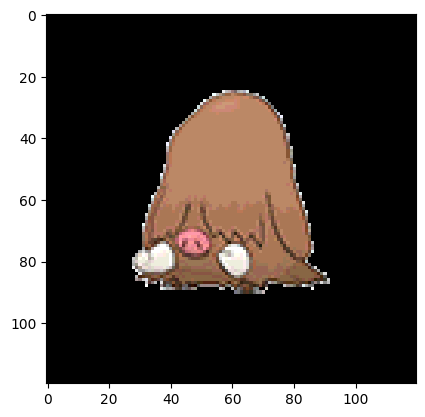

In [5]:
import matplotlib.image as mpimg

images = df.iloc[:,0]
X_train = []

for img in images:
  image = mpimg.imread(img)

  image = image[:,:,:3]
  X_train.append(image)

y_train = df.iloc[:,1]
y_train = pds.get_dummies(y_train, dtype = int)
y_train = y_train.values.tolist()

X_train = np.array(X_train)
y_train = np.array(y_train)

plt.imshow(X_train[0])
images.size

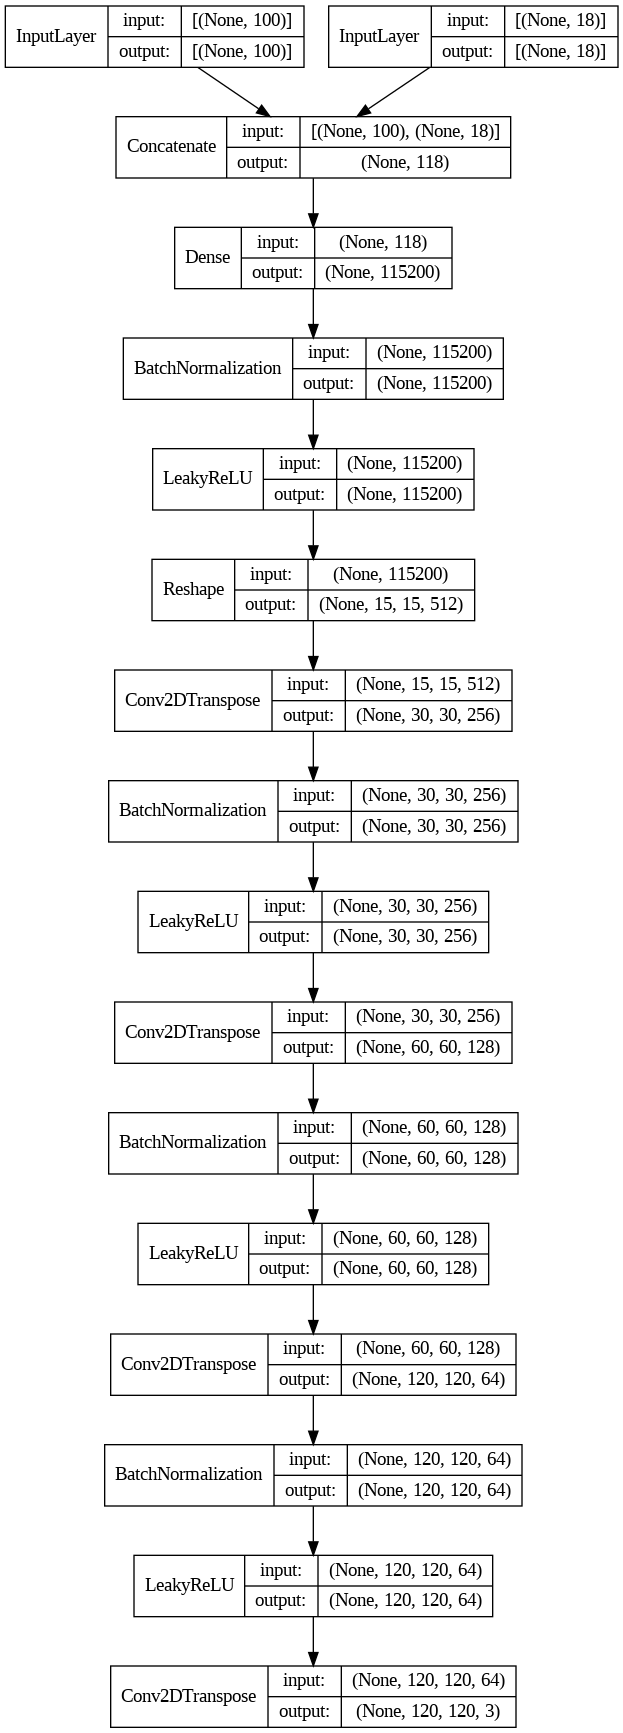

In [7]:
def generador_de_imagenes():

    input = Input(shape=(100,))
    input_label = Input(shape=(18))

    x = Concatenate(axis=1)([input, input_label])

    x = (Dense(512*15*15))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((15,15,512))(x)

    x = Conv2DTranspose(256,kernel_size=3, strides=2, padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64,kernel_size=3, strides=2, padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    output = Conv2DTranspose(3,kernel_size=3, padding = "same", activation='tanh')(x)

    generador = Model(inputs=[input, input_label], outputs=output, name='generador')

    return generador

modelo_generador = generador_de_imagenes()
plot_model(modelo_generador, show_shapes=True, show_layer_names=False)

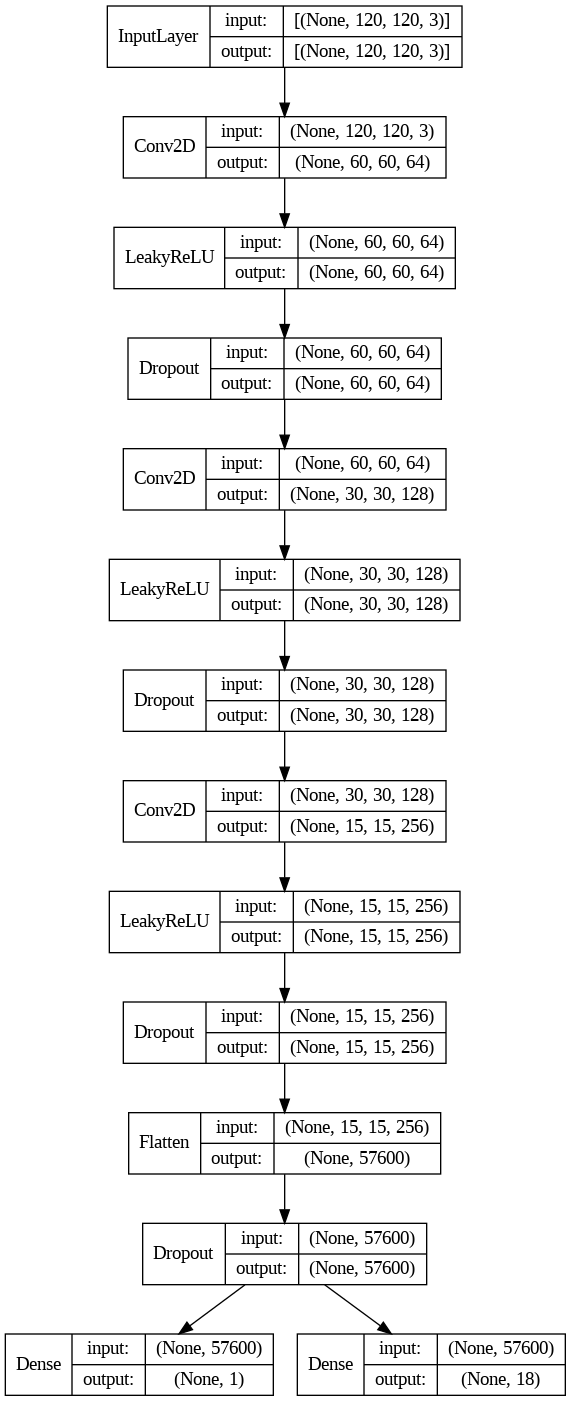

In [15]:
def discriminador_de_imagenes():

    input = Input(shape = (120,120,3))

    #x = Conv2D(32, kernel_size=3, padding = "same")(input)
    #x = LeakyReLU(alpha=0.2)(x)
    #x = Dropout(0.2)(x)

    x = Conv2D(64, kernel_size=3,strides=(2,2), padding = "same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, kernel_size=3,strides=(2,2), padding = "same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=3, strides=(2,2), padding = "same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    output_label = Dense(18, activation='softmax')(x)


    discriminador = Model(inputs=input, outputs=[output, output_label], name='discriminador')

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
plot_model(modelo_discriminador, show_shapes=True, show_layer_names=False)

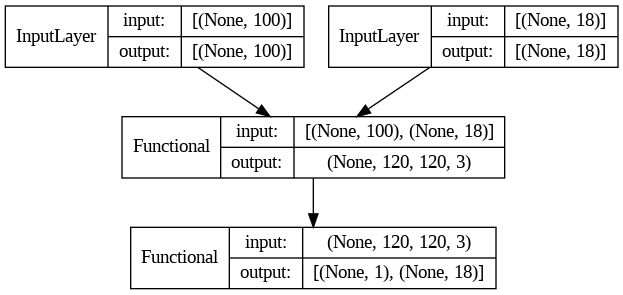

In [16]:
modelo_discriminador.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
modelo_discriminador.trainable = False

z = Input(shape=(100,))
label = Input(shape=(18))
img = modelo_generador([z, label])

validity, target_label = modelo_discriminador(img)

combined = Model([z,label], [validity, target_label])
combined.compile(loss='binary_crossentropy', optimizer=Adam())

plot_model(combined, show_shapes=True, show_layer_names=False)

In [17]:
def generate_random_labels(batch_size, array_length):
    batch = []
    for _ in range(batch_size):
        arr = np.zeros(array_length)

        random_position = random.randint(0, array_length - 1)
        arr[random_position] = 1

        batch.append(arr)

    return np.array(batch)

In [18]:
def train(X_train, y_train, modelo_generador, modelo_discriminador, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (-1 fake and 1 real)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Entrenar el Discriminador
            noise = np.random.normal(0, 1, (batch_size, 100))
            # Generar un batch de etiquetas de manera aleatoria
            gen_labels = generate_random_labels(batch_size, 18)
            # El generador ahora deberá admitir el noise la mismo tiempo que los gen_labels generados aleatoriamente
            gen_imgs = modelo_generador.predict([noise, gen_labels], verbose=0)

            imgs = X_train[batch*batch_size : (batch+1)*batch_size]
            # Obtener el batch correspondiente de etiquetas de y_train
            img_labels = y_train[batch*batch_size : (batch+1)*batch_size]

            # Añadir a las salidas deseadas del discriminador las etiquetas aleatorias y las obtenidas de y_train
            d_loss_real = modelo_discriminador.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = modelo_discriminador.train_on_batch(gen_imgs, [fake, gen_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Entrenar el Generador
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generar un batch de etiquetas de manera aleatoria
            gen_labels = generate_random_labels(batch_size, 18)

            # Añadir como entrada y salida las etiquetas generadas
            g_loss = combined.train_on_batch([noise, gen_labels], [valid, gen_labels])

            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[3])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[3], g_loss[0]))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels)

        plot_losses(history)

In [19]:
def sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0,i].imshow(gen_imgs[i,:,:,0], cmap='Greys')
        axs[0,i].set_title(np.where(gen_labels[i]==1))
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(imgs[i,:,:,0], cmap='Greys')
        axs[1,i].set_title(np.where(img_labels[i]==1))
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [20]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

----EPOCH 0-----
0 [D loss: 3.9161,	 acc.: 10.94%]	[G loss: 0.6557]


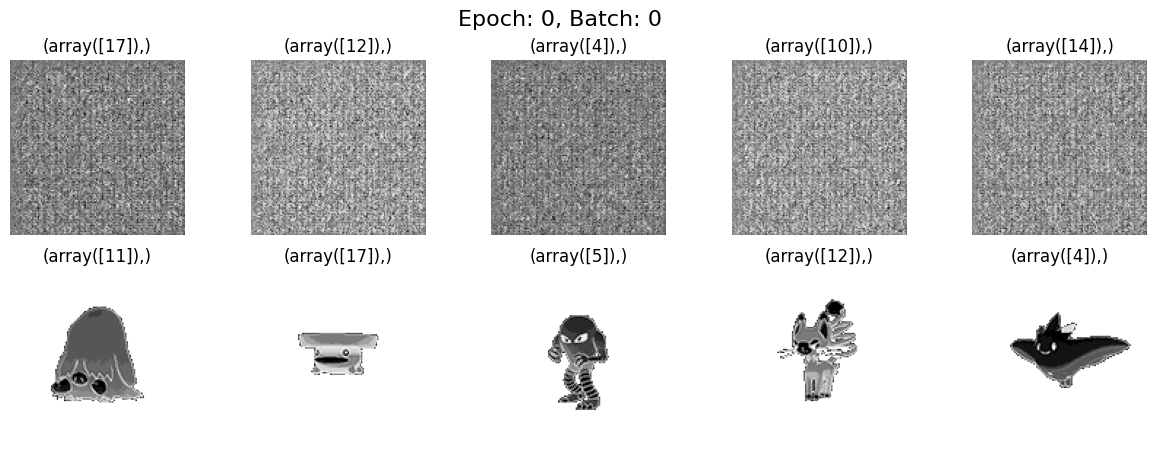

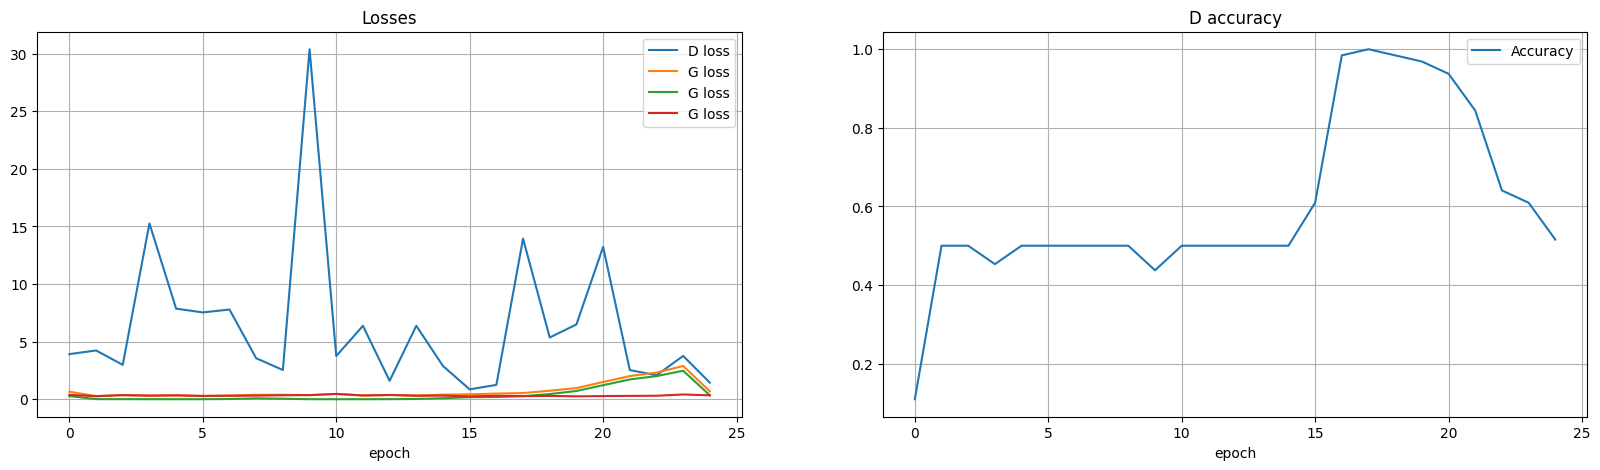

----EPOCH 1-----
0 [D loss: 2.4948,	 acc.: 50.00%]	[G loss: 0.4672]


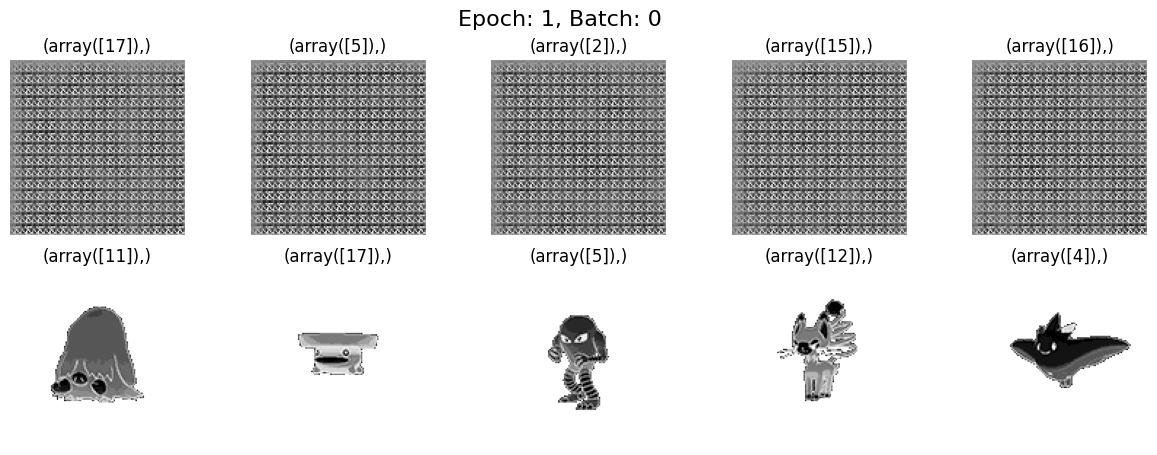

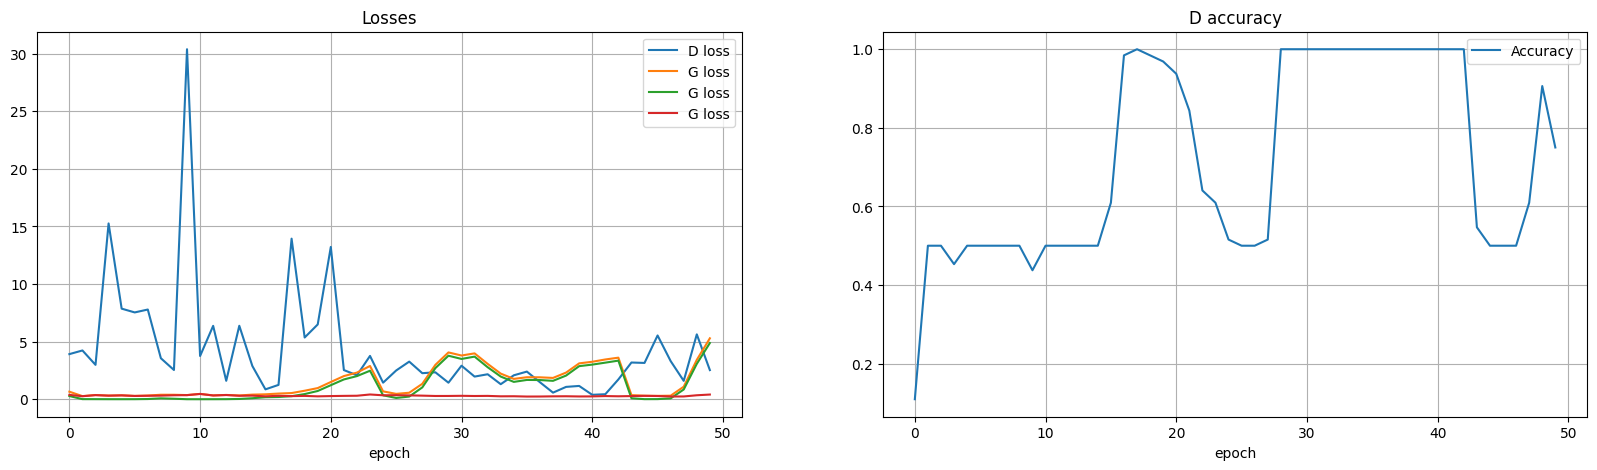

----EPOCH 2-----
0 [D loss: 2.5022,	 acc.: 67.19%]	[G loss: 6.0983]


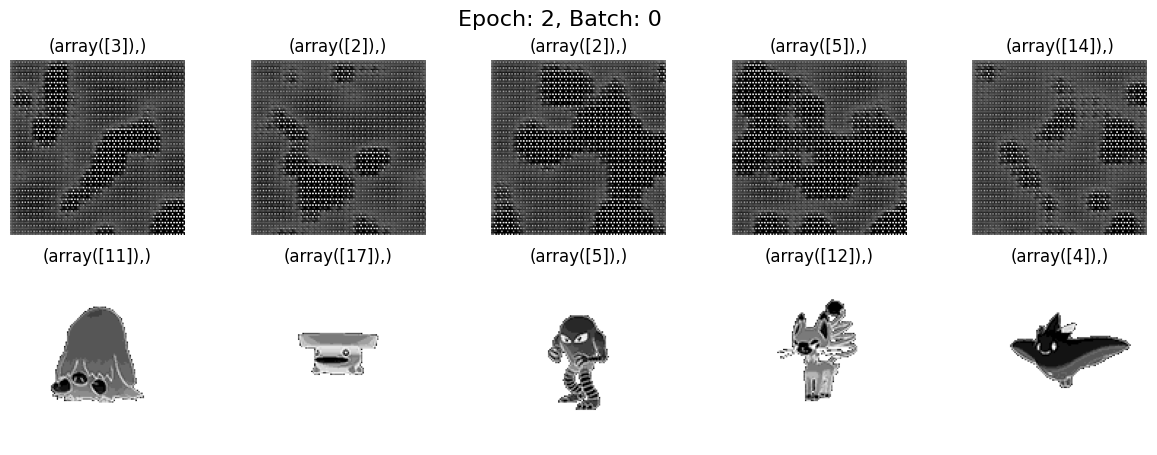

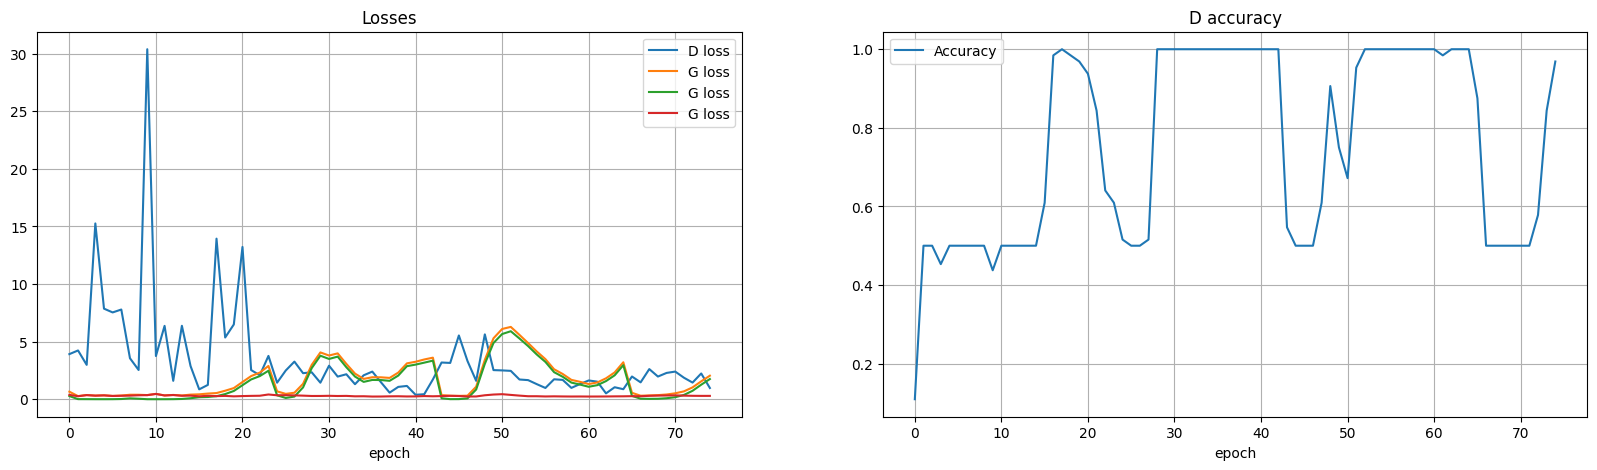

----EPOCH 3-----
0 [D loss: 1.5326,	 acc.: 98.44%]	[G loss: 2.4764]


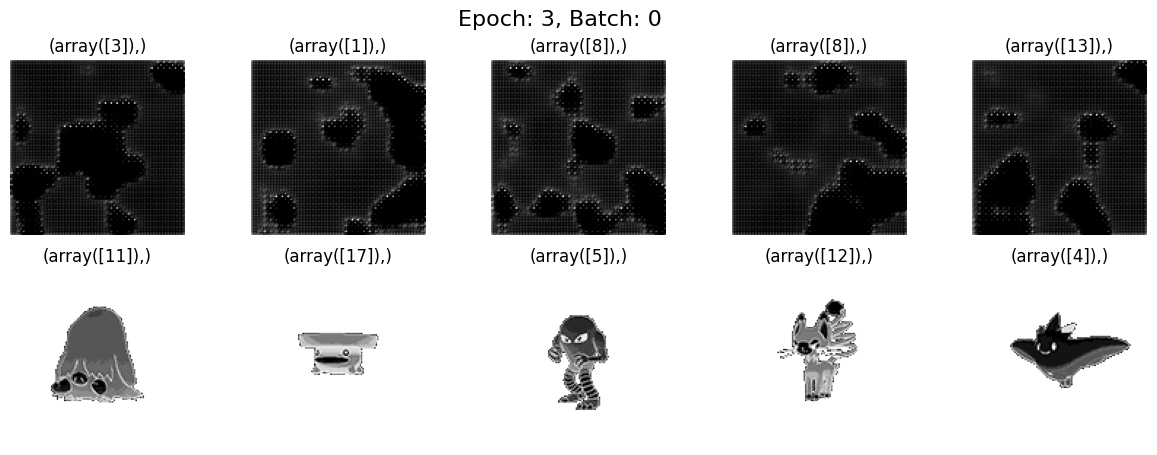

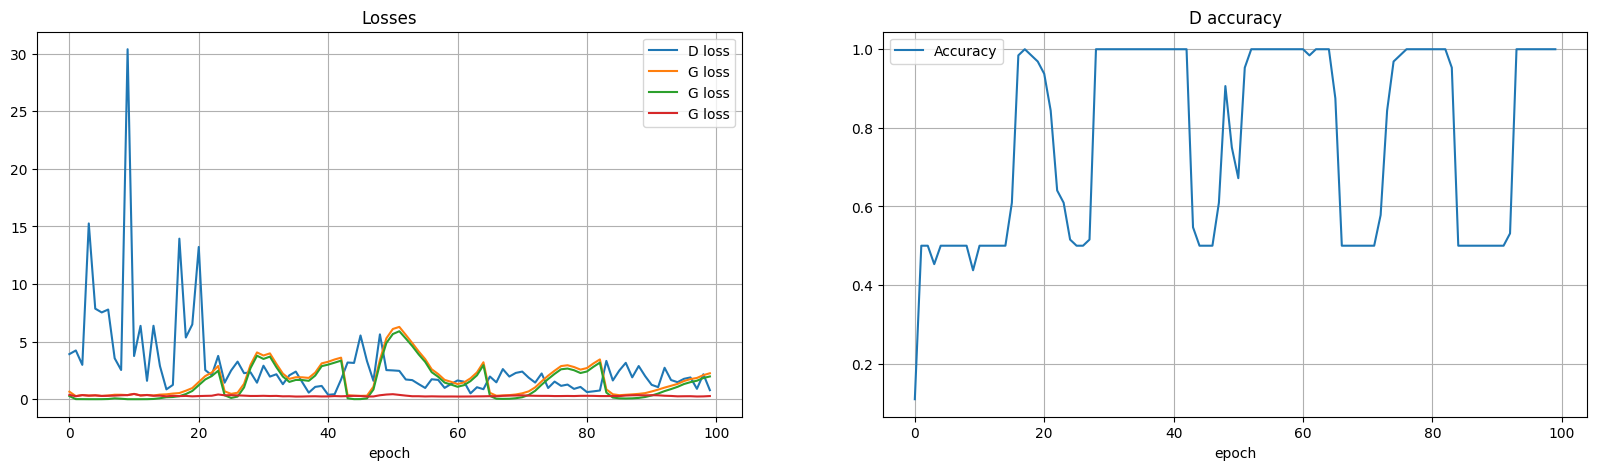

----EPOCH 4-----
0 [D loss: 1.0007,	 acc.: 100.00%]	[G loss: 2.4088]


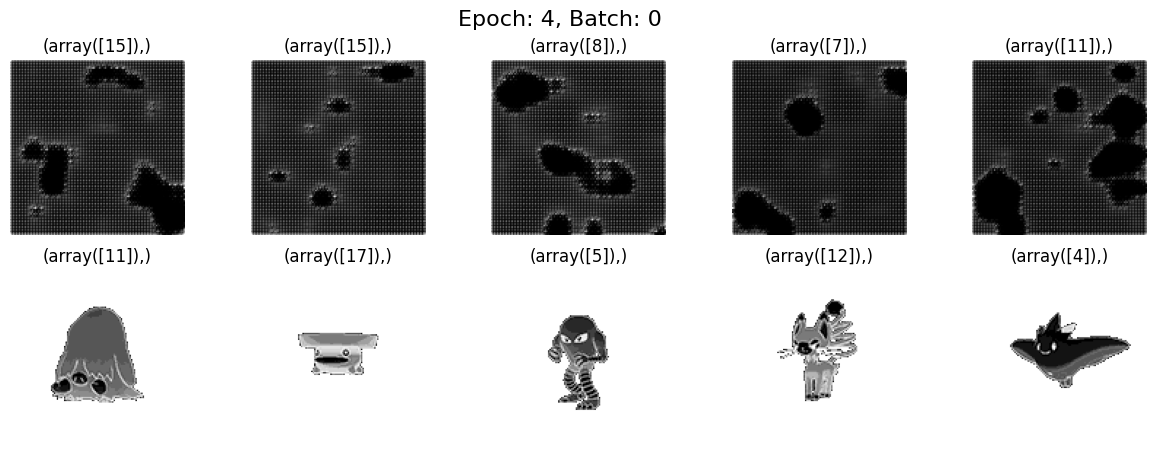

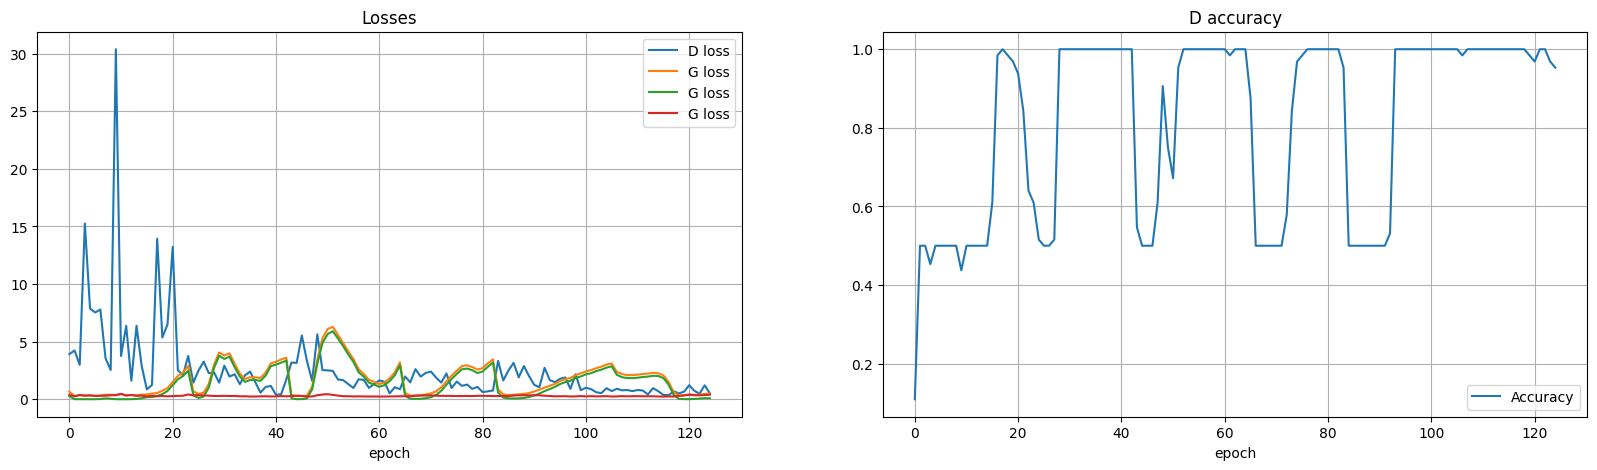

----EPOCH 5-----
0 [D loss: 0.5442,	 acc.: 100.00%]	[G loss: 0.4801]


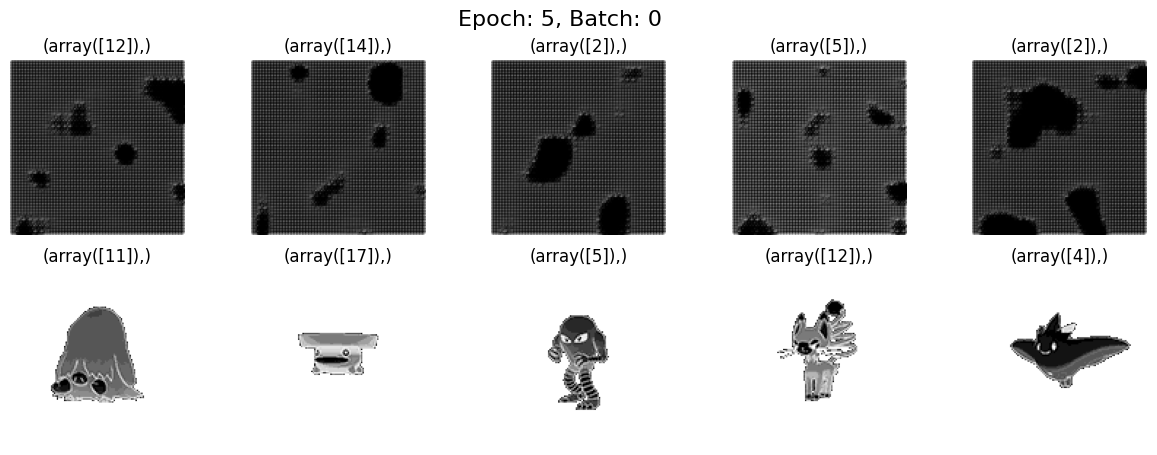

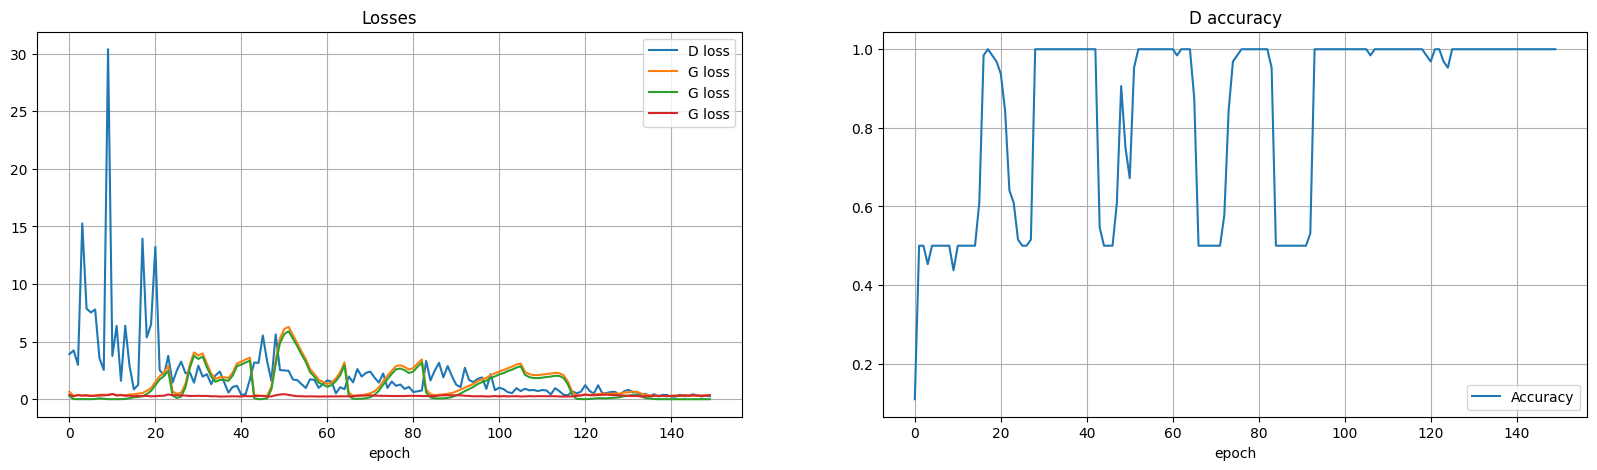

----EPOCH 6-----
0 [D loss: 0.3156,	 acc.: 100.00%]	[G loss: 0.3427]


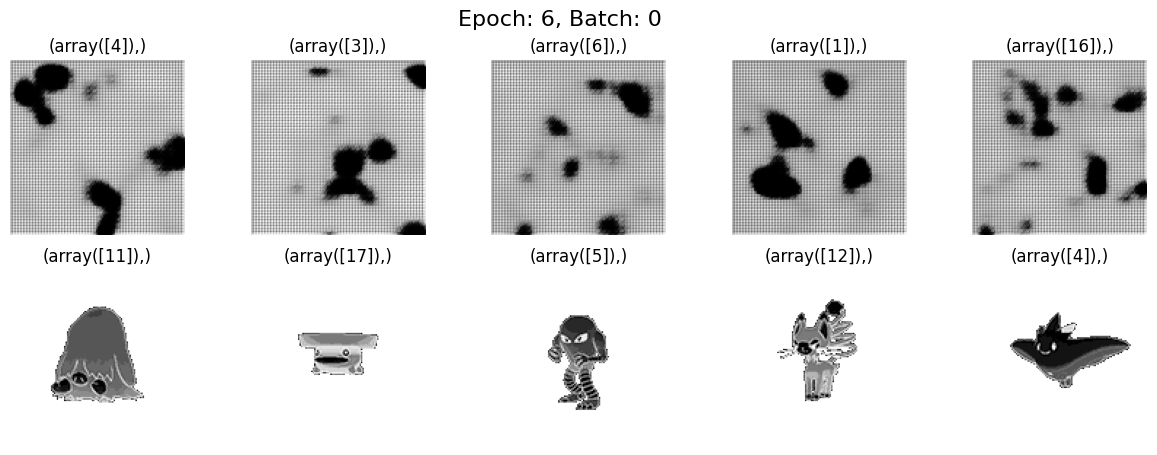

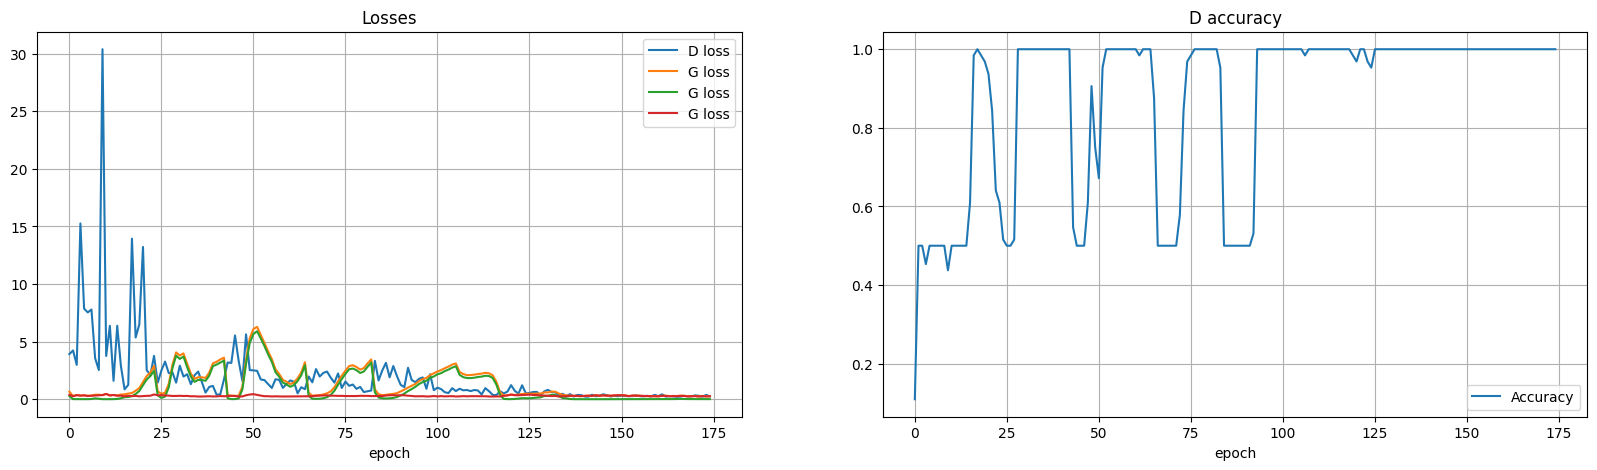

----EPOCH 7-----
0 [D loss: 0.2685,	 acc.: 100.00%]	[G loss: 0.2553]


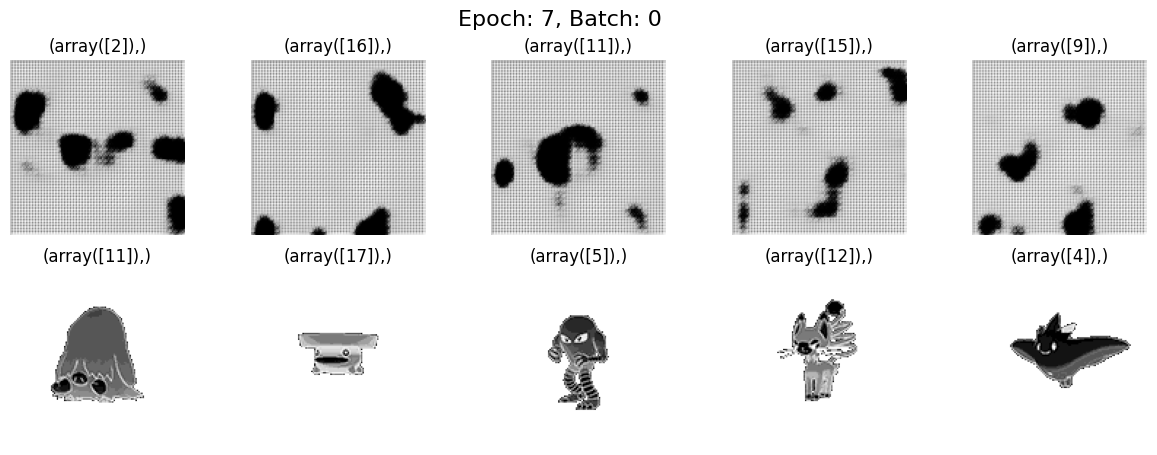

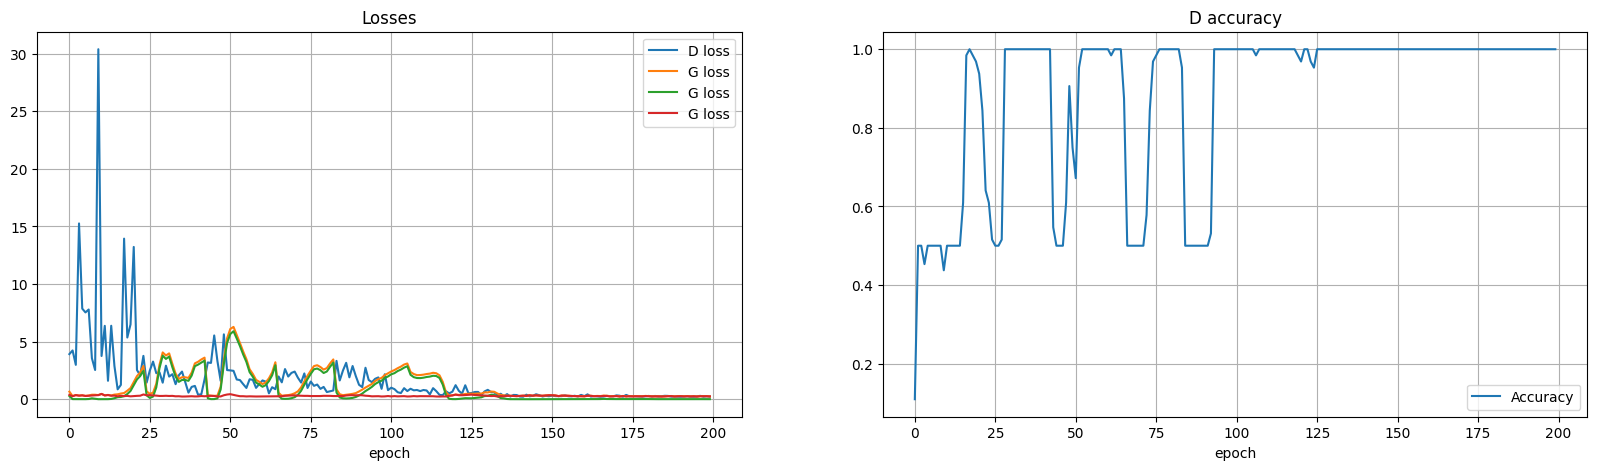

----EPOCH 8-----
0 [D loss: 0.2806,	 acc.: 100.00%]	[G loss: 0.2512]


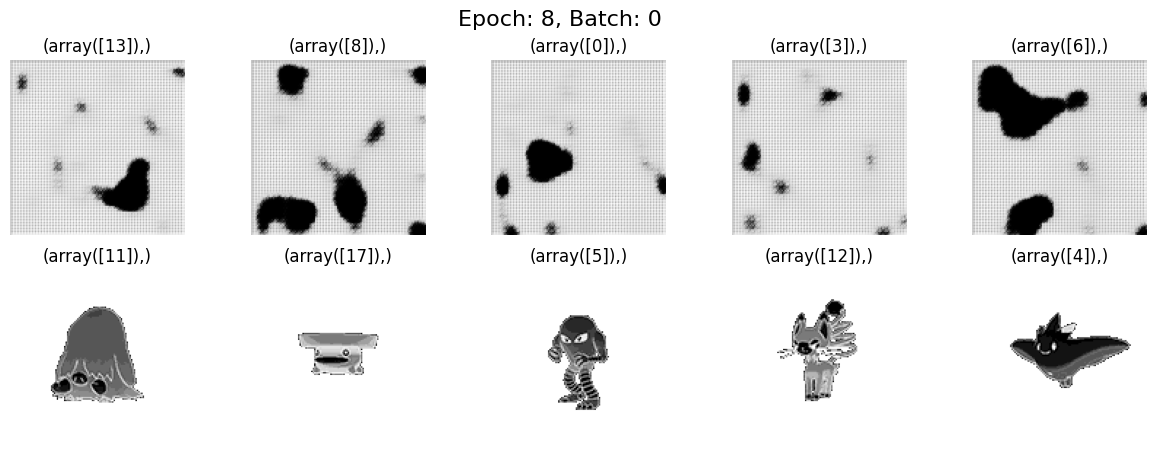

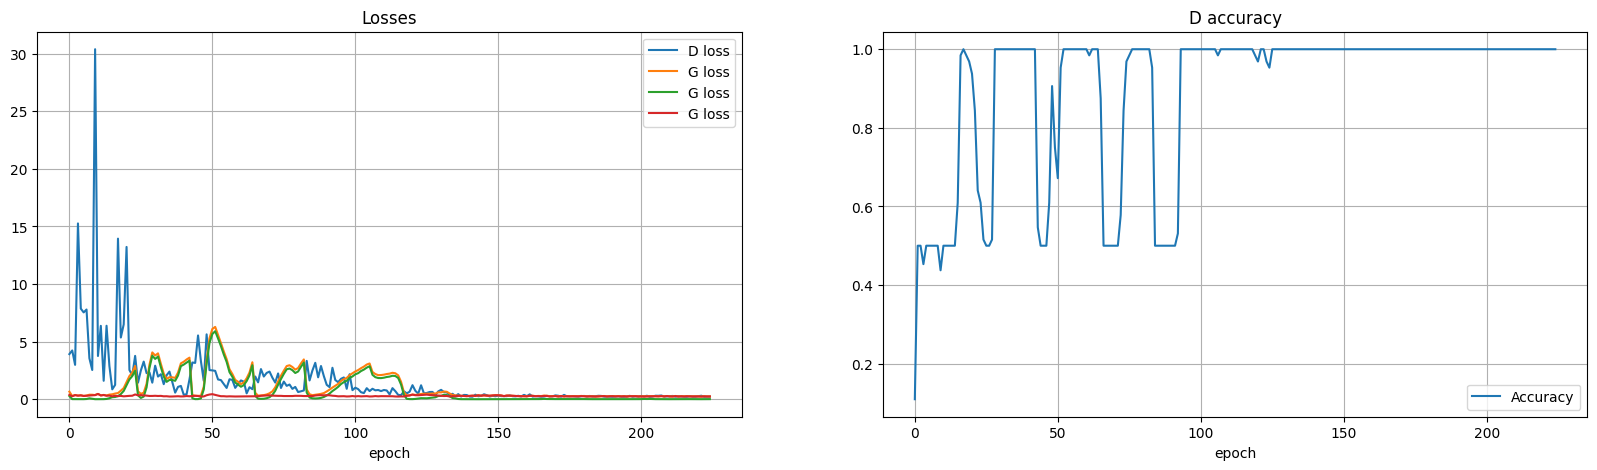

----EPOCH 9-----
0 [D loss: 0.2586,	 acc.: 100.00%]	[G loss: 0.2294]


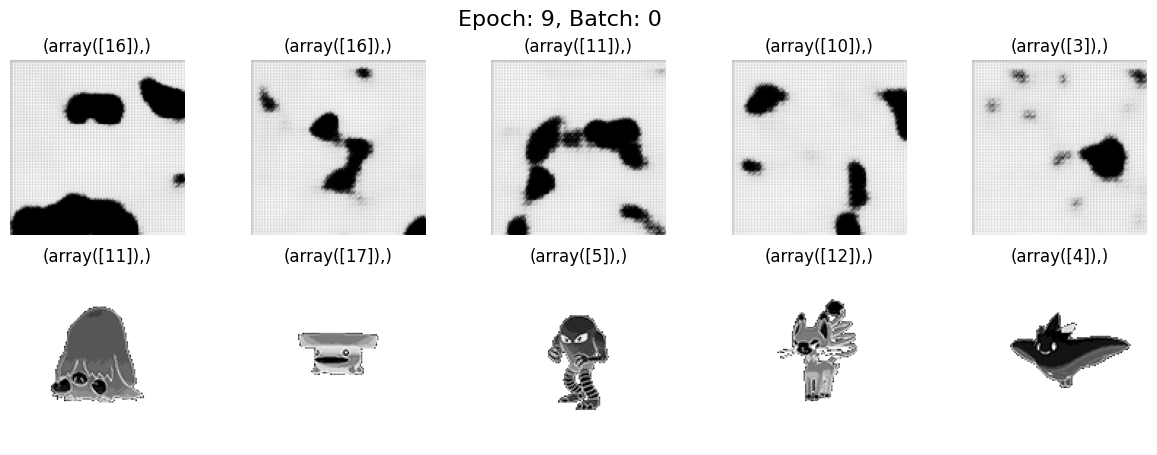

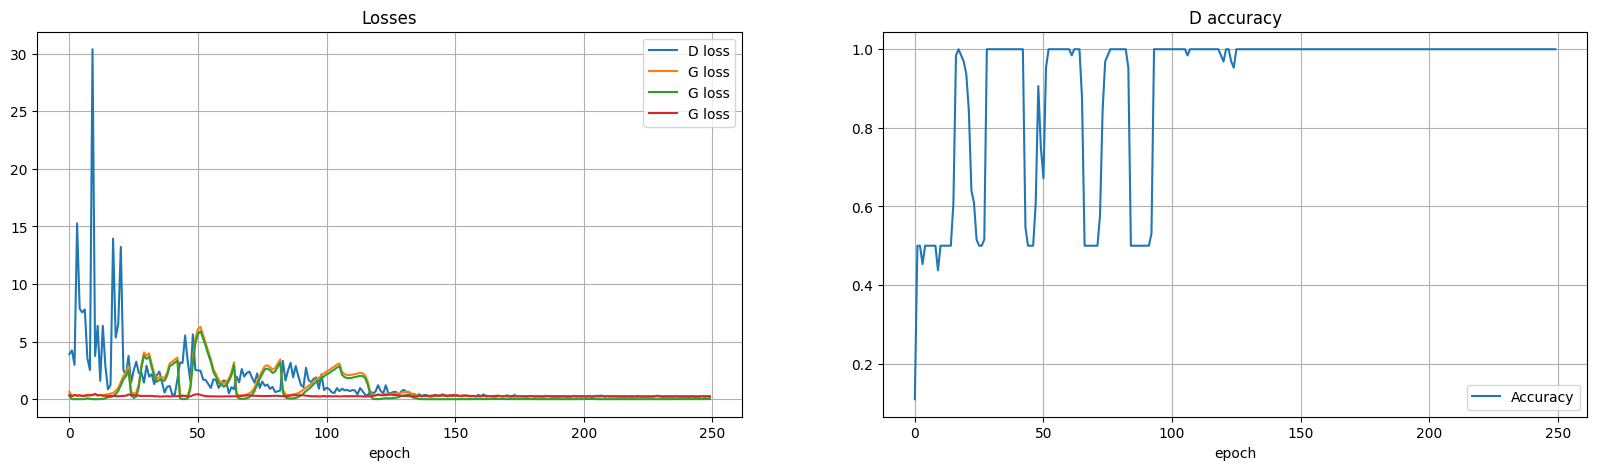

----EPOCH 10-----
0 [D loss: 0.2351,	 acc.: 100.00%]	[G loss: 0.2728]


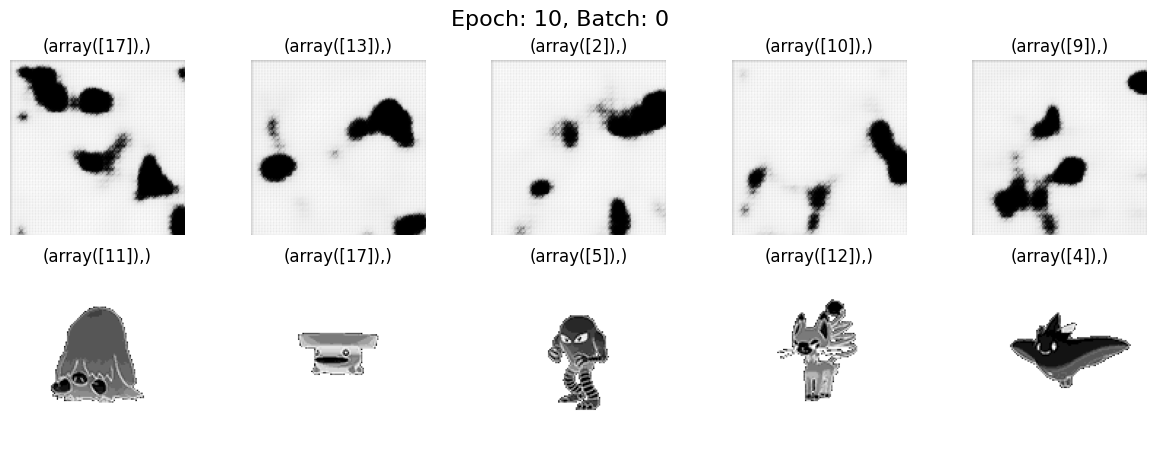

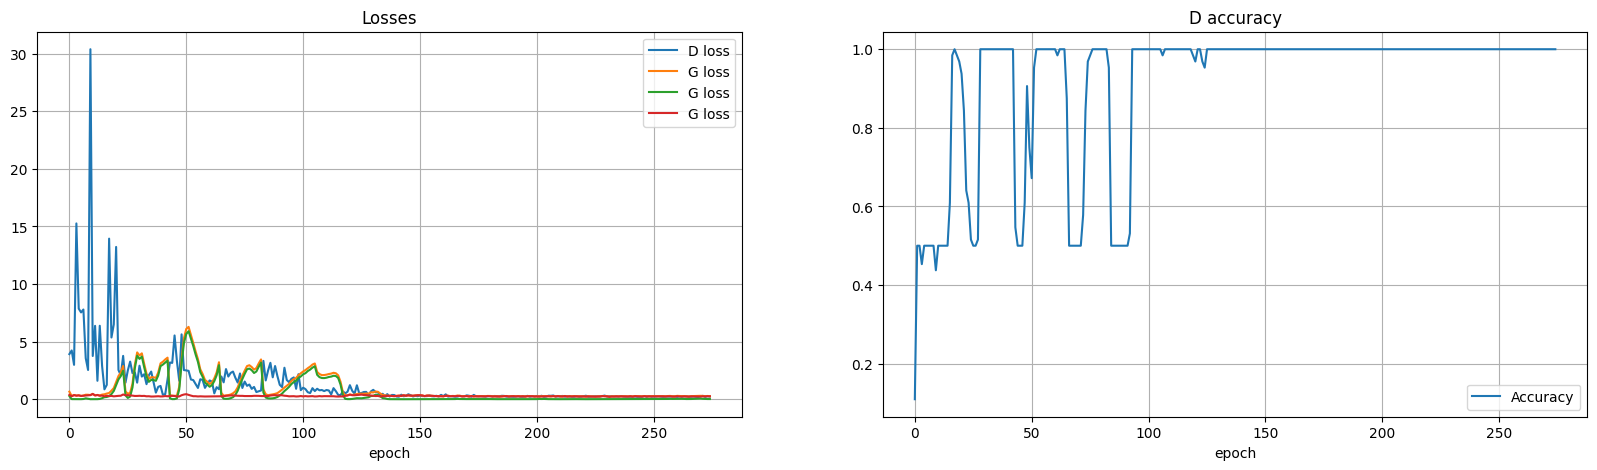

----EPOCH 11-----
0 [D loss: 0.2605,	 acc.: 100.00%]	[G loss: 0.2462]


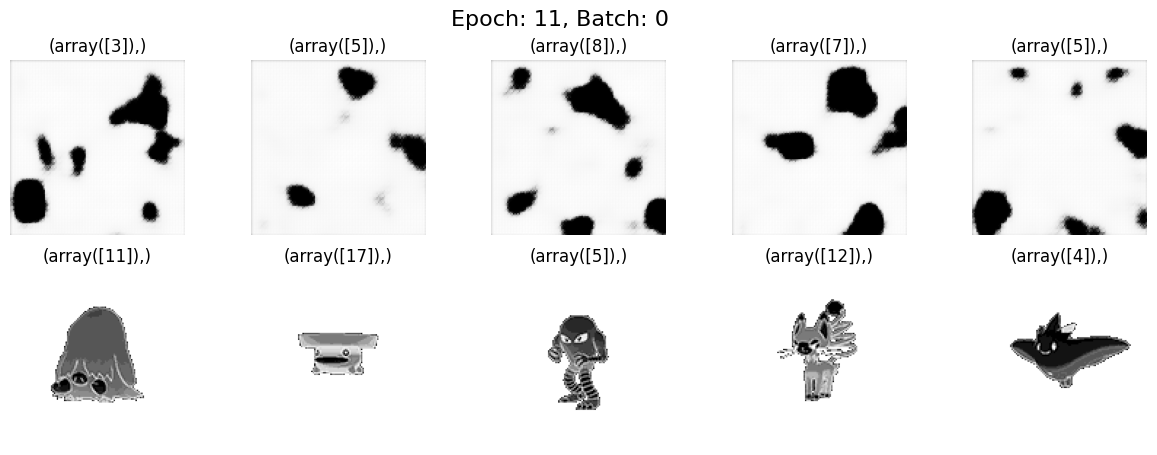

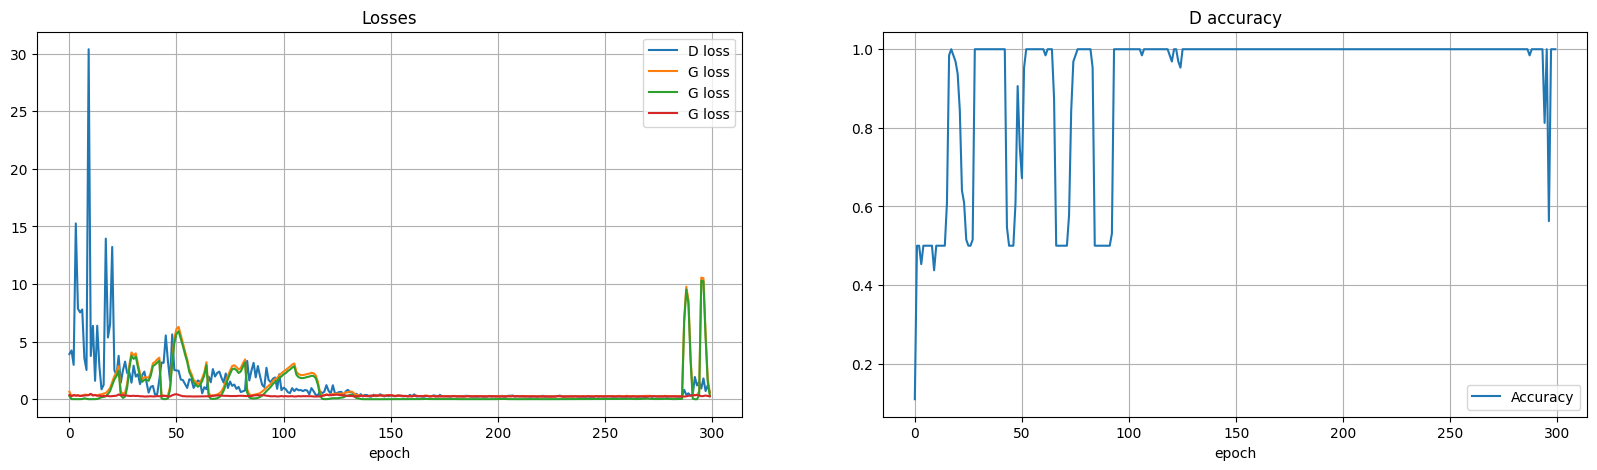

----EPOCH 12-----
0 [D loss: 1.0724,	 acc.: 100.00%]	[G loss: 0.9535]


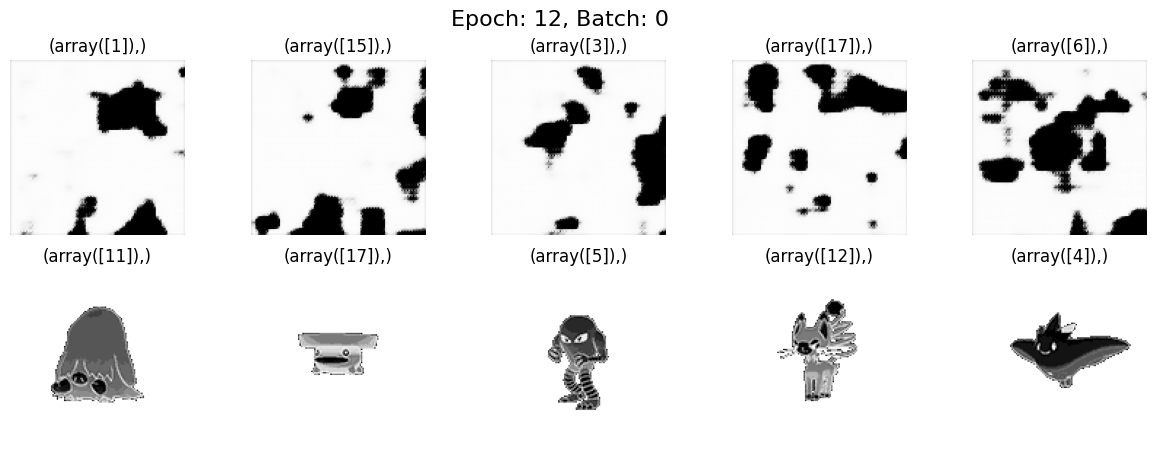

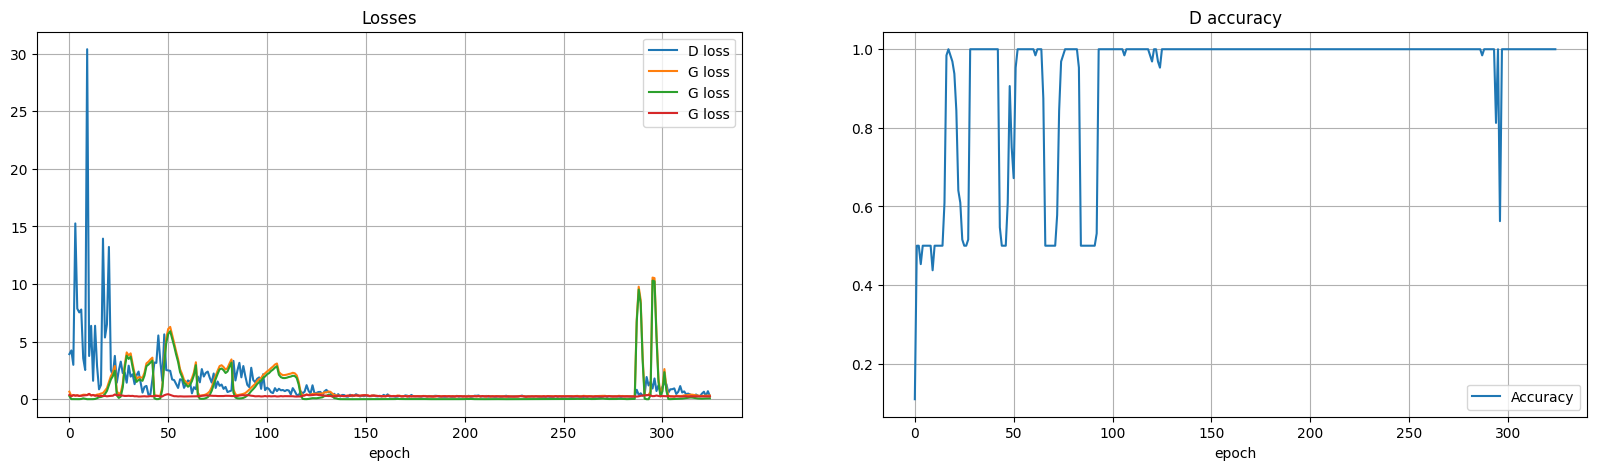

----EPOCH 13-----
0 [D loss: 0.4029,	 acc.: 100.00%]	[G loss: 0.3278]


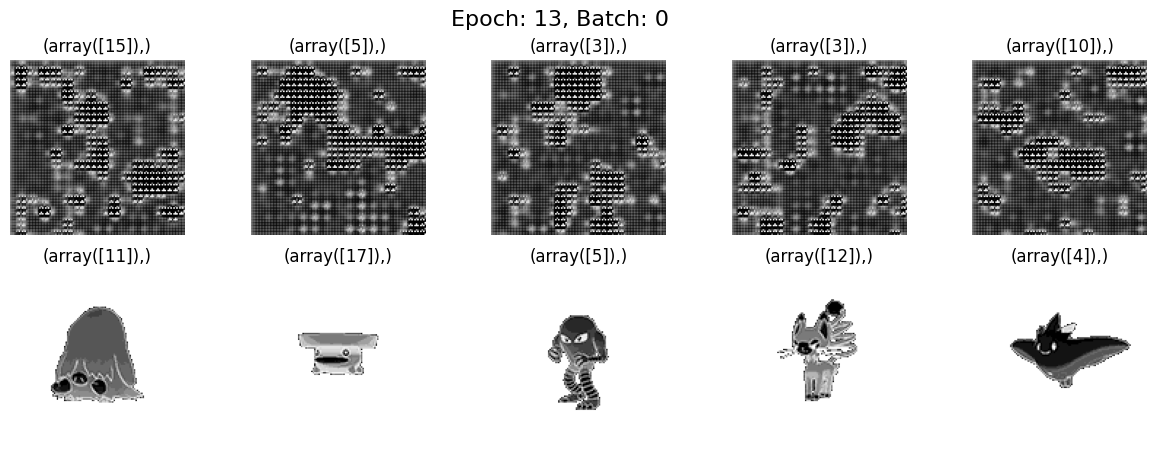

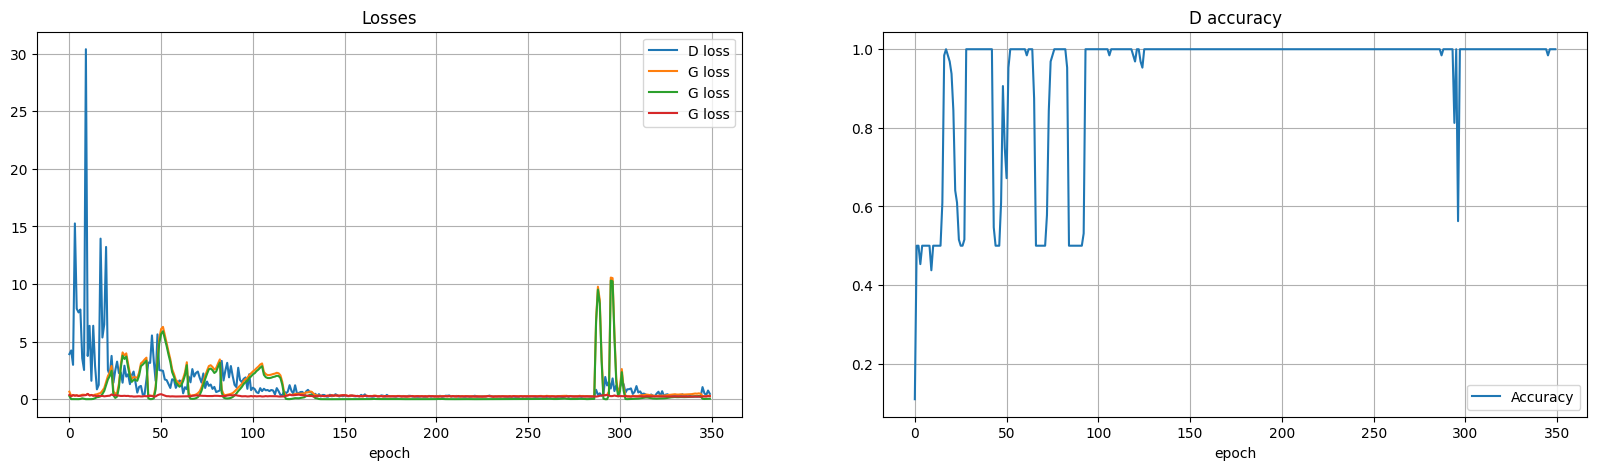

----EPOCH 14-----
0 [D loss: 0.8616,	 acc.: 100.00%]	[G loss: 0.2914]


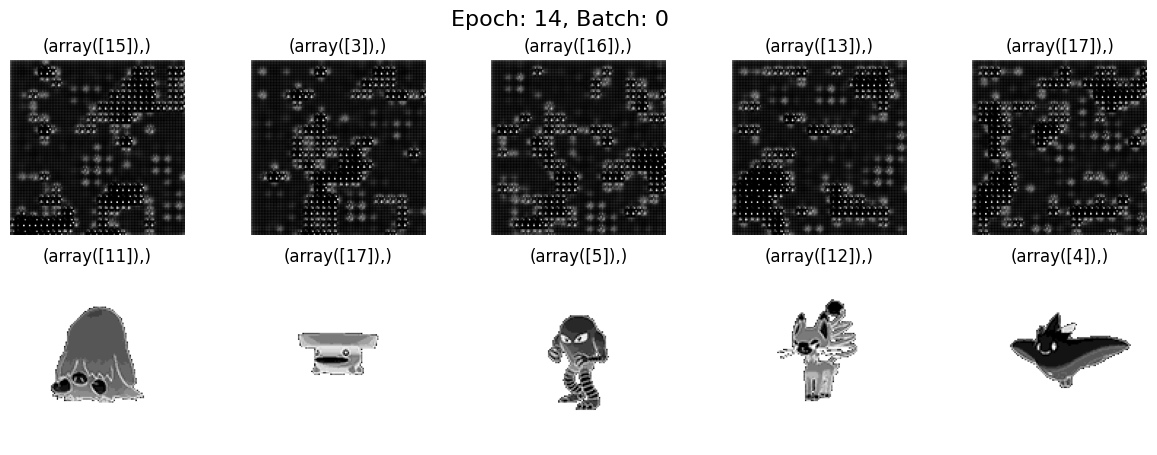

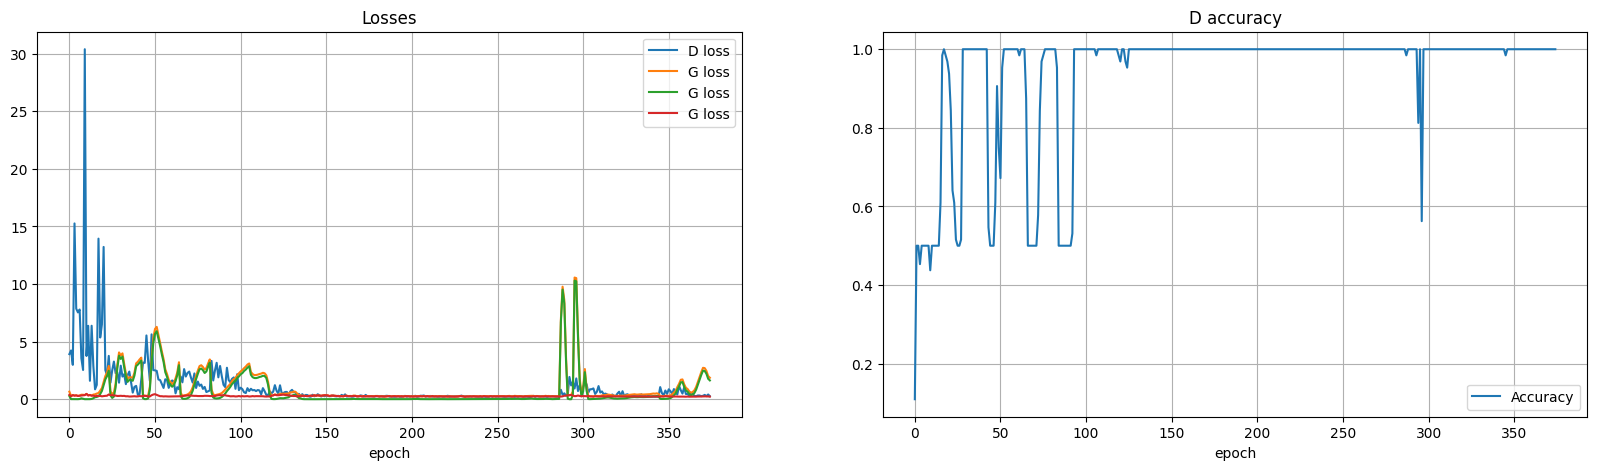

----EPOCH 15-----
0 [D loss: 0.3661,	 acc.: 100.00%]	[G loss: 1.9370]


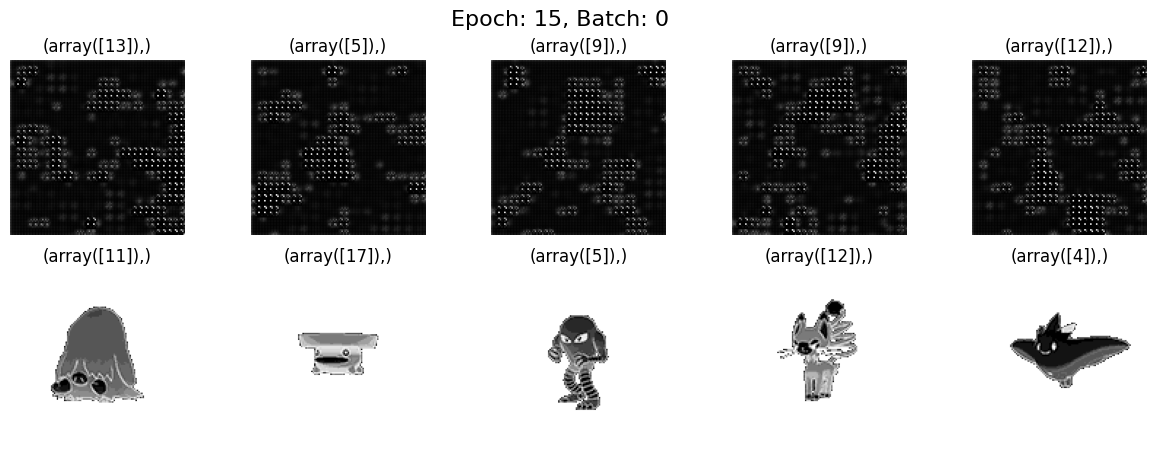

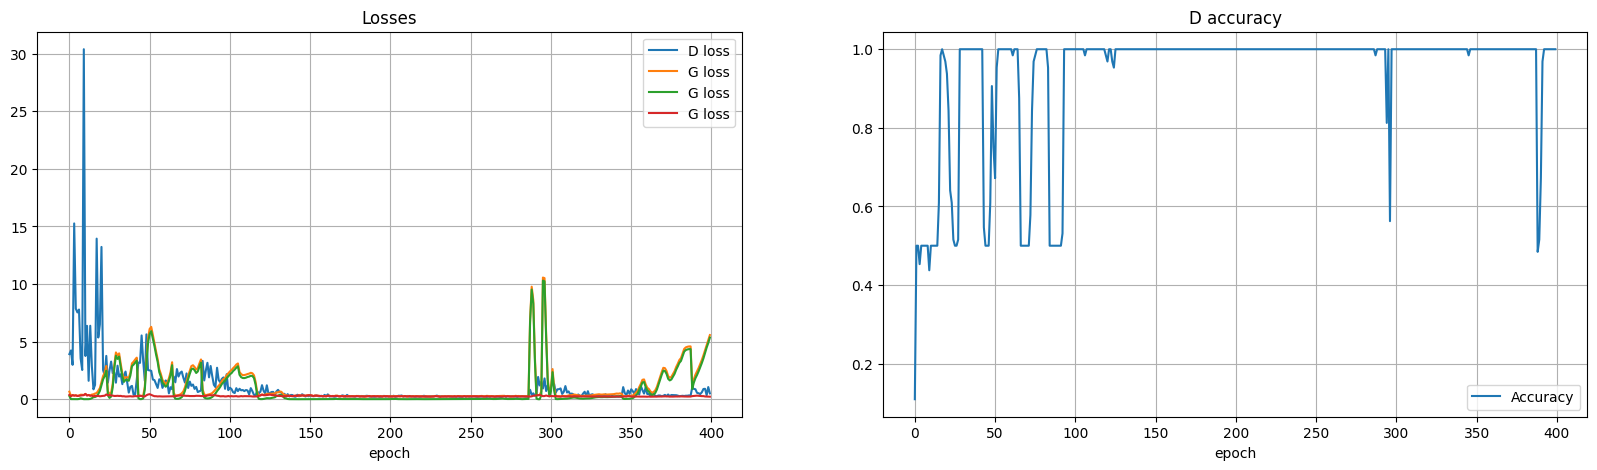

----EPOCH 16-----
0 [D loss: 0.5602,	 acc.: 100.00%]	[G loss: 5.9598]


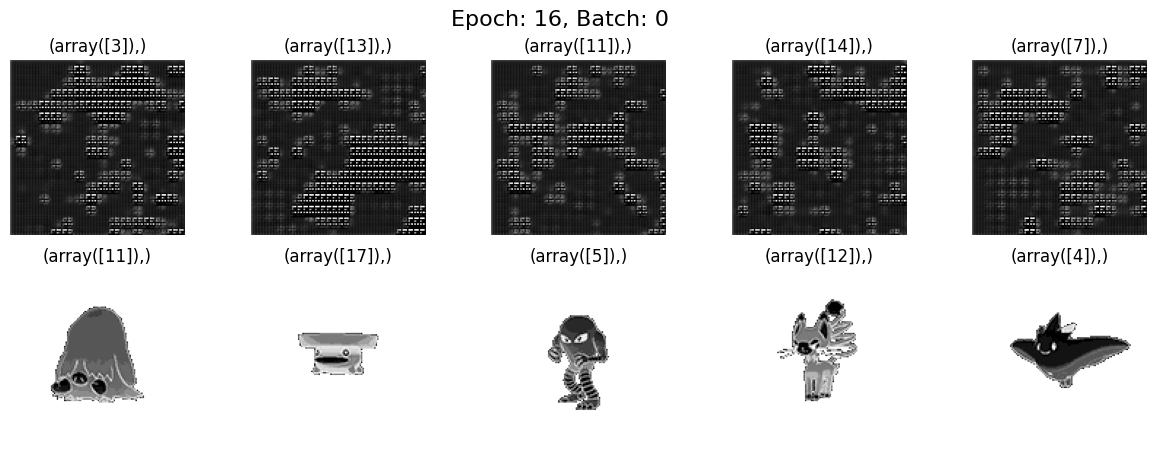

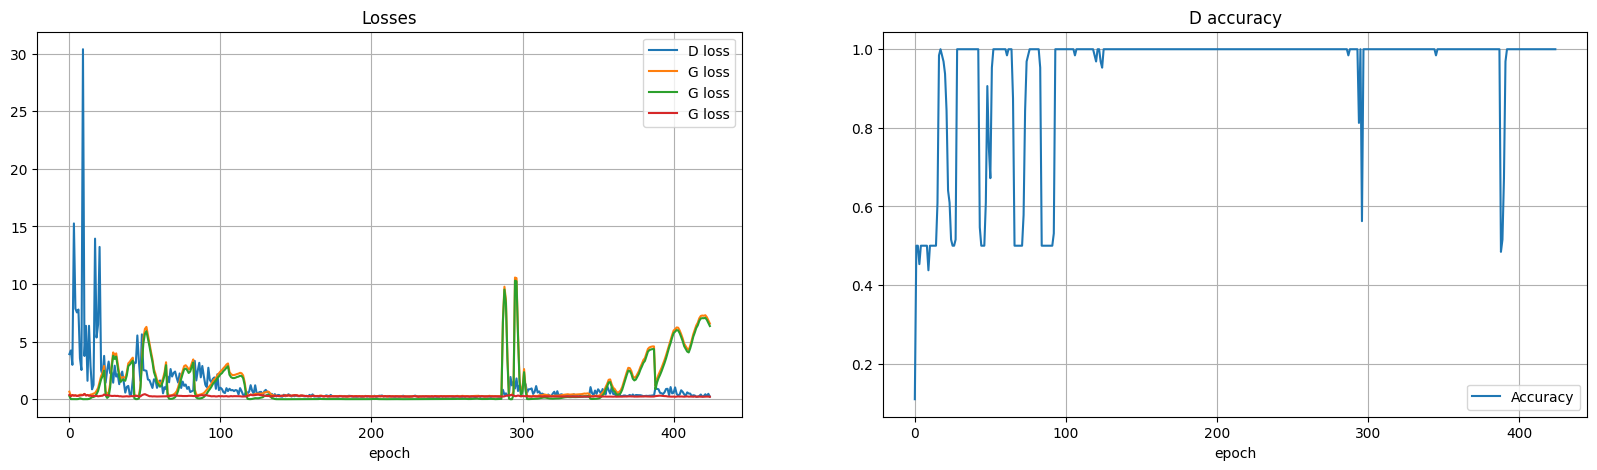

----EPOCH 17-----
0 [D loss: 0.3355,	 acc.: 100.00%]	[G loss: 6.1712]


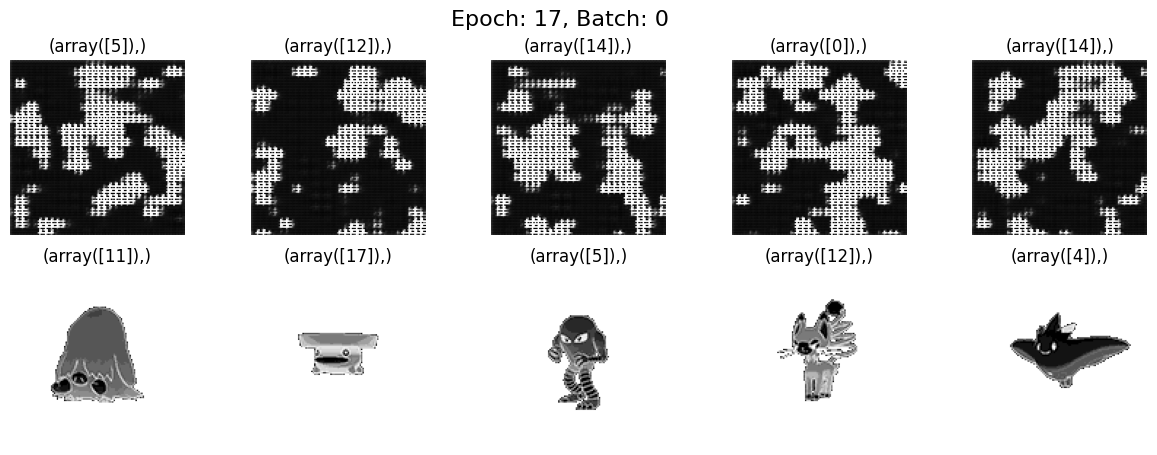

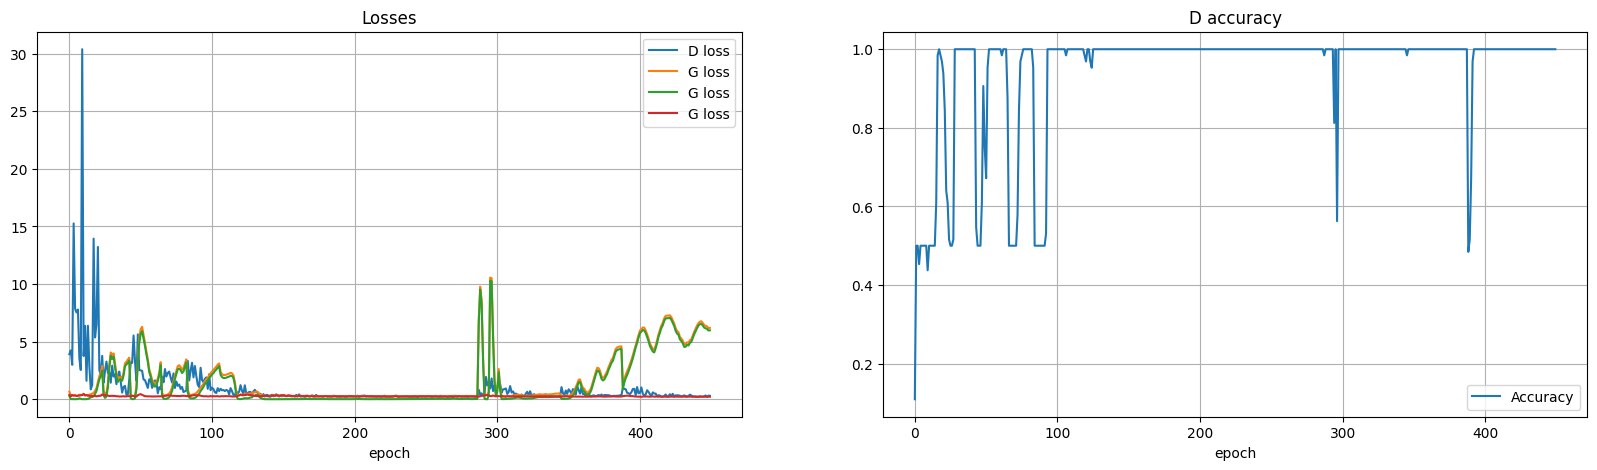

----EPOCH 18-----
0 [D loss: 0.3090,	 acc.: 100.00%]	[G loss: 6.1646]


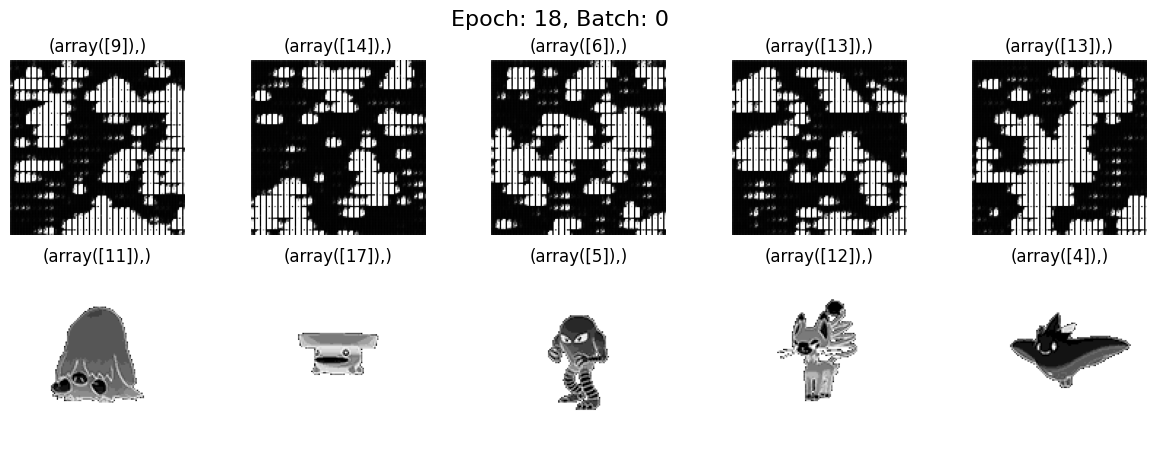

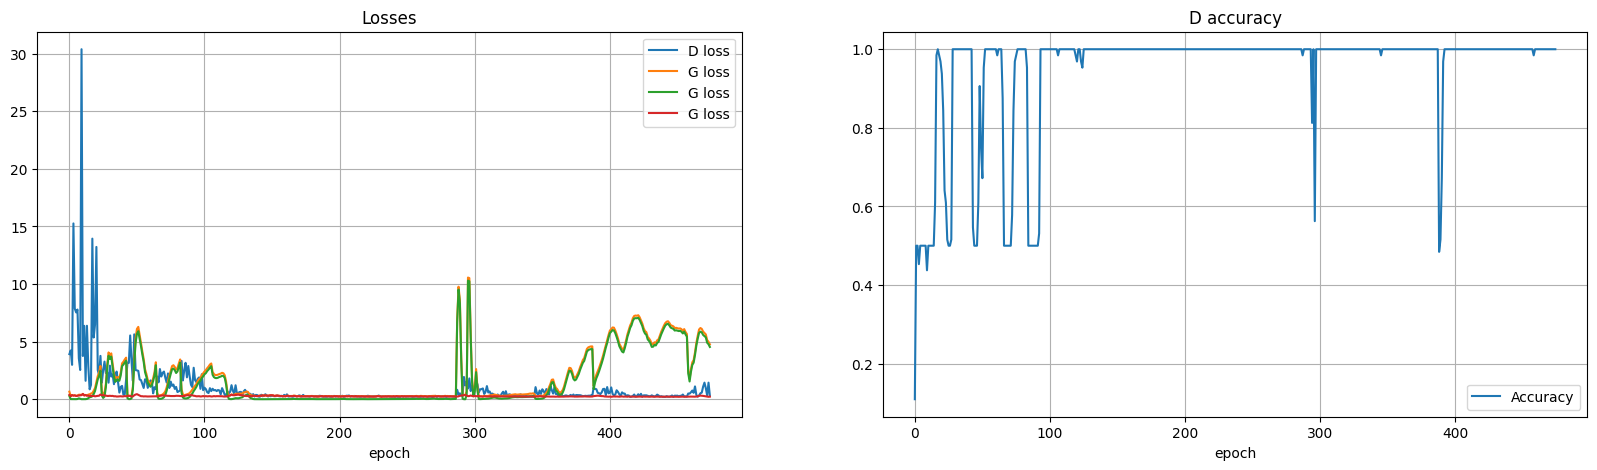

----EPOCH 19-----
0 [D loss: 0.7691,	 acc.: 100.00%]	[G loss: 4.6655]


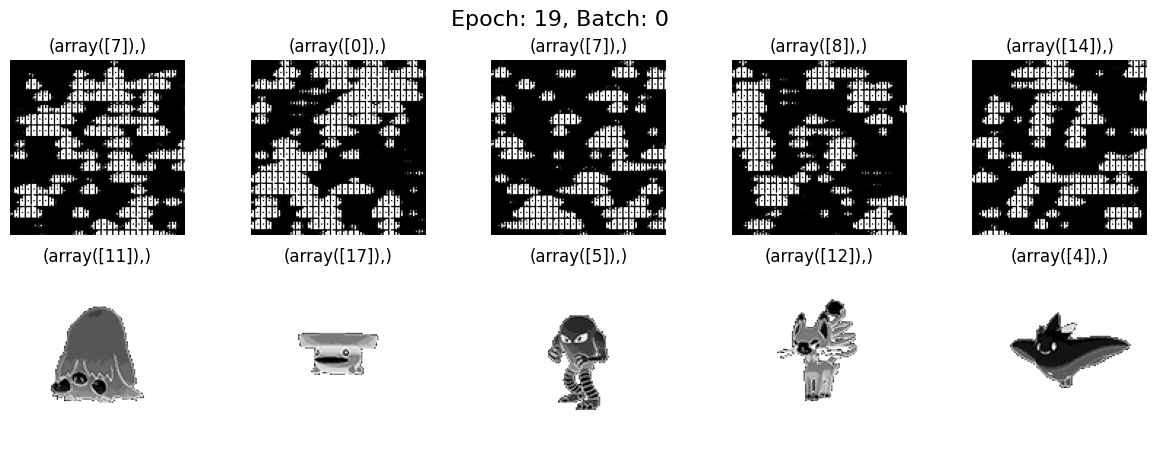

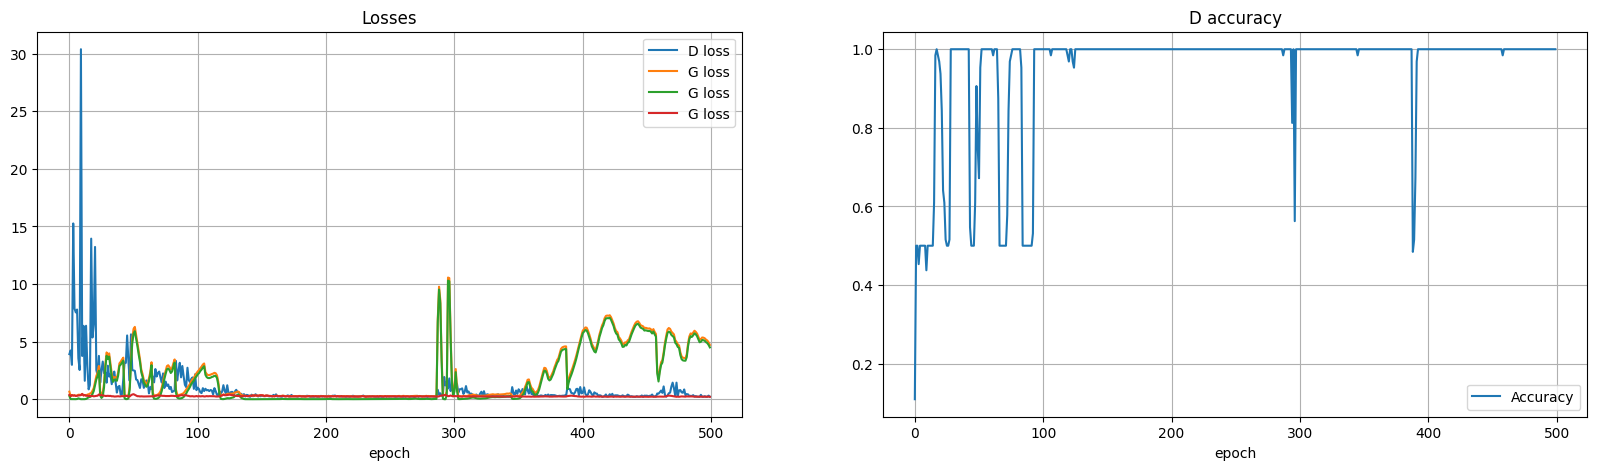

In [21]:
train(X_train, y_train, modelo_generador, modelo_discriminador, combined, epochs=20, batch_size=32, sample_interval=100)